# TinyML sur Arduino
## Projet TinyML
## Compatible Windows



**Objectif :** Créer un modèle de reconnaissance de gestes qui peut fonctionner sur un microcontrôleur Arduino.

**Materiels necessaire:**
- Arduino Nano 33 BLE Sense (avec accéléromètre et gyroscope intégrés)
- Fichiers CSV contenant les données d'entrainement

### Biblioteques Necessaires

Dans ce notebook sont utilisés les librairies python suivantes
- **Numpy:** Manipulation de tableaux et calculs mathematiques
- **Pandas:** Lecture et manipulation de fichiers CSV
- **Matplotlib:** Visualisation de données (graphiques)
- **Tensorflow:** Framework de machine learning pour la creation et l'entrainment de reseau de neurones

### Compatibilité Python
- **Tensorflow necessite python 3.8 à 3.11**
- Vous pouvez aussi creer un environnement virtuel  avec Python 3.11

## Vibrations utilisés : no_vibration, secouer_vibration, telephone_vibration



---

### Vibration :  no_vibration

**Description**  
Aucune vibration , nano ble 33 en stand by 

### Vibration :  nsecouer_vibration

**Description**  
On secoue la nano ble 33 de haut en bas

### Vibration :  telephone_vibration

**Description**  
On lance une appli de vibration puis on pose le telephone au dessus de la nano ble 33

## 📁 Charger les données

### Préparation des fichiers

Donc on a trois fichiers qui correspondent a nos trois vibrations distinctes

- `no_vibration.csv` 
- `secouer_vibration.csv` 
- `telephone_vibration.csv` 

### Format des données

Chaque fichier CSV contient des colonnes :
- `aX`, `aY`, `aZ` : Accélération sur les axes X, Y, Z (en G)
- `gX`, `gY`, `gZ` : Vitesse angulaire (gyroscope) sur les axes X, Y, Z (en deg/s)

## 📊 Visualisation de données

### Deux graphiques séparés

Nous créons deux graphiques distincts pour l'accélération et le gyroscope car :
- **Unités différentes** : Accélération en G, gyroscope en deg/s
- **Échelles différentes** : Les valeurs n'ont pas la même amplitude
- **Facilite l'analyse** : Permet de mieux comprendre chaque type de mesure

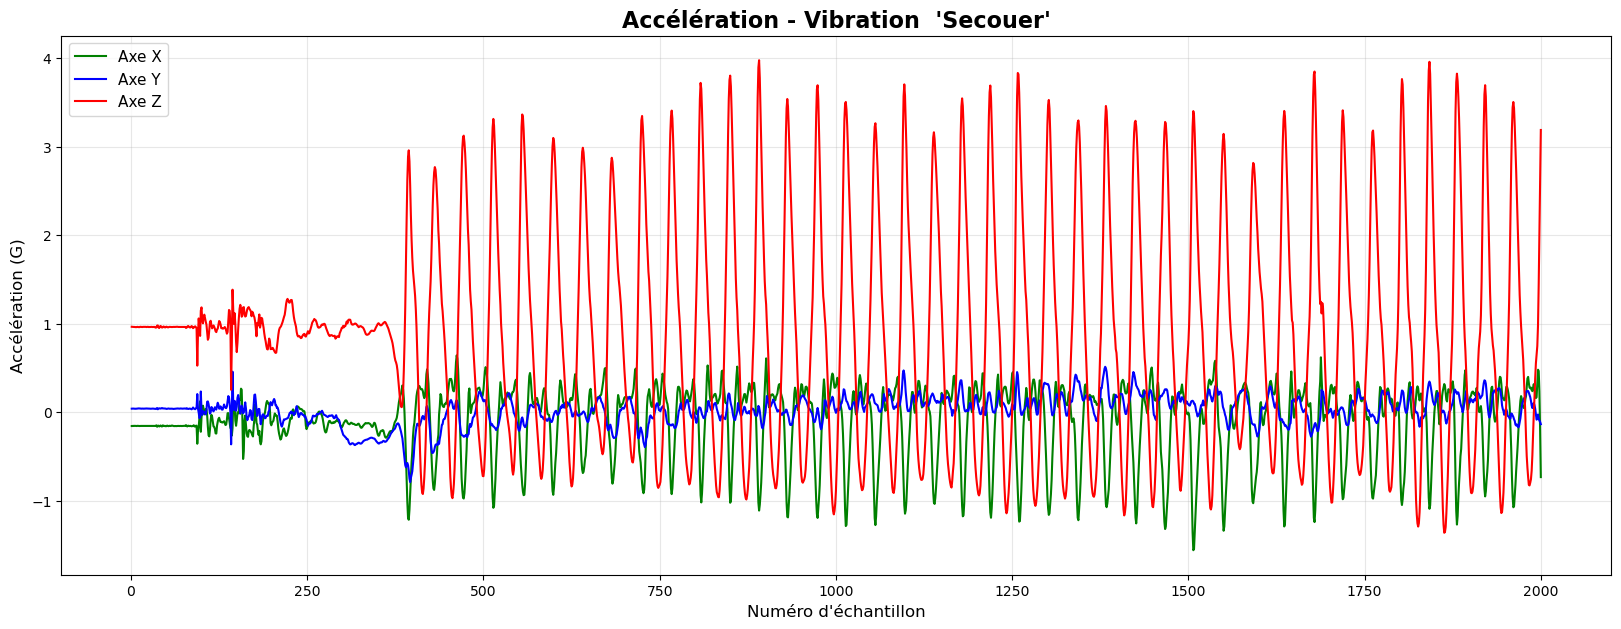

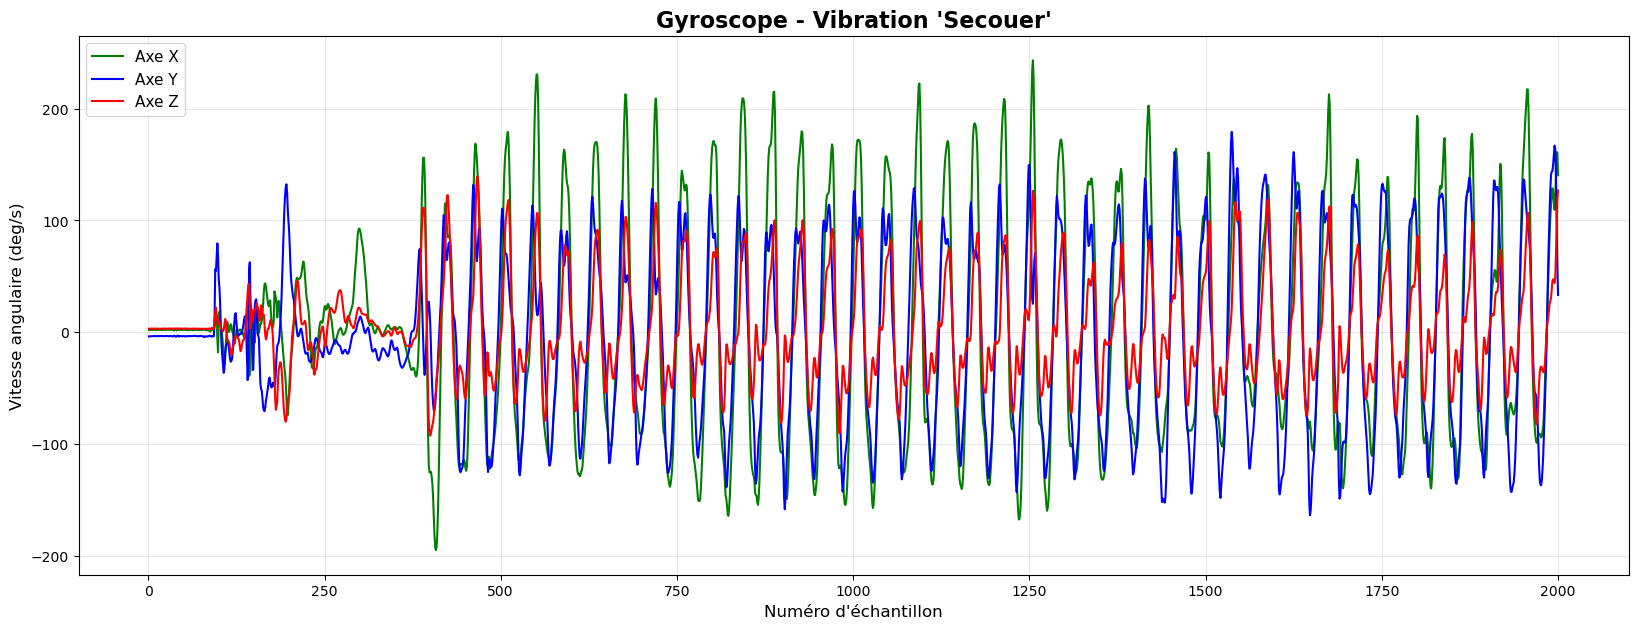

✓ Visualisation terminée. Vous pouvez voir les patterns du geste 'secouer'.


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Charger les données de la vibration "secouer_vibration" 
filename = r"../dataset/secouer_vibration.csv"

# Utiliser le chemin relatif pour compatibilité Windows
df = pd.read_csv(filename)

# Créer un index pour l'axe X (numéro d'échantillon)
index = range(1, len(df['aX']) + 1)

# Définir la taille des graphiques (largeur, hauteur en pouces)
plt.rcParams["figure.figsize"] = (20, 7)

# Graphique 1 : Accélération
# Les couleurs : vert (g) pour X, bleu (b) pour Y, rouge (r) pour Z
plt.plot(index, df['aX'], 'g-', label='Axe X', linewidth=1.5)
plt.plot(index, df['aY'], 'b-', label='Axe Y', linewidth=1.5)
plt.plot(index, df['aZ'], 'r-', label='Axe Z', linewidth=1.5)
plt.title("Accélération - Vibration  'Secouer'", fontsize=16, fontweight='bold')
plt.xlabel("Numéro d'échantillon", fontsize=12)
plt.ylabel("Accélération (G)", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

# Graphique 2 : Gyroscope
plt.plot(index, df['gX'], 'g-', label='Axe X', linewidth=1.5)
plt.plot(index, df['gY'], 'b-', label='Axe Y', linewidth=1.5)
plt.plot(index, df['gZ'], 'r-', label='Axe Z', linewidth=1.5)
plt.title("Gyroscope - Vibration 'Secouer'", fontsize=16, fontweight='bold')
plt.xlabel("Numéro d'échantillon", fontsize=12)
plt.ylabel("Vitesse angulaire (deg/s)", fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print("✓ Visualisation terminée. Vous pouvez voir les patterns du geste 'secouer'.")

## Extraction de features

### Extractionn de features au niveau de l'acceleration
- **Energie**
- **RMS**
- **Variance**
### Extraction de features au niveau du gyroscope
- **Energie**
- **RMS**
- **Variance**

Donc chaque 100 echantillons de données correspondra à une ligne de ces 6 features

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print(f"Version TensorFlow = {tf.__version__}\n")

# ============================================
# REPRODUCTIBILITÉ
# ============================================
# Définir une graine aléatoire fixe pour obtenir les mêmes résultats
# à chaque exécution. Important pour la reproductibilité des expériences.
SEED = 1400
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ============================================
# CONFIGURATION DES Vibrations
# ============================================
# Liste des vibrations à reconnaître (doit correspondre aux noms des fichiers CSV)
VIBRATIONS = [
    "no_vibration",  
    "secouer_vibration",
    "telephone_vibration"
]

# Nombre d'échantillons par geste (100 échantillons = ~2 seconde à 50Hz)
SAMPLES_PER_VIBRATION = 100

NUM_VIBRATIONS = len(VIBRATIONS)

# ============================================
# ONE-HOT ENCODING
# ============================================
# Créer une matrice d'encodage one-hot pour les sorties
# no_vibration → [1, 0, 0]
# secouer_vibration → [0, 1, 0]
# telephone_vibration → [0, 0, 1]
ONE_HOT_ENCODED_VIBRATIONS = np.eye(NUM_VIBRATIONS)
print("Encodage one-hot:")
for i, vibration in enumerate(VIBRATIONS):
    print(f"  {vibration}: {ONE_HOT_ENCODED_VIBRATIONS[i]}")

# ============================================
# PRÉPARATION DES DONNÉES
# ============================================
inputs = []  # Liste des entrées (données normalisées)
outputs = []  # Liste des sorties (labels one-hot)

# Parcourir chaque fichier CSV de vibration
for vibration_index in range(NUM_VIBRATIONS):
    vibration = VIBRATIONS[vibration_index]
    print(f"\n📁 Traitement de l'index {vibration_index} pour la vibration '{vibration}'...")

    # Récupérer le vecteur one-hot correspondant à cette vibration
    output = ONE_HOT_ENCODED_VIBRATIONS[vibration_index]

    # Lire le fichier CSV
    df = pd.read_csv(f"../dataset/{vibration}.csv")

    # Supprimer les lignes vides qui causeraient des erreurs (NaN)
    df = df.dropna()
    df = df.reset_index(drop=True)

    # Calculer le nombre d'enregistrements de cette vibration dans le fichier
    # Chaque enregistrement = SAMPLES_PER_VIBRATION échantillons
    num_recordings = int(df.shape[0] / SAMPLES_PER_VIBRATION)
    print(f"   ✓ {num_recordings} enregistrement(s) de la vibration '{vibration}' trouvé(s)")

    # Pour chaque enregistrement de la vibration
    for i in range(num_recordings):
        tensor = []  # Vecteur d'entrée pour cet enregistrement
        
        # Pour chaque échantillon dans cet enregistrement
        sum_a = 0.0
        sum_a2 = 0.0
        sum_g = 0.0
        sum_g2 = 0.0
        for j in range(SAMPLES_PER_VIBRATION):
            index = i * SAMPLES_PER_VIBRATION + j
            
            # Calculer la magnitude de l'accélération et du gyroscope
            a_mag = np.sqrt(
                df['aX'][index]**2 +
                df['aY'][index]**2 +
                df['aZ'][index]**2
            )

            g_mag = np.sqrt(
                df['gX'][index]**2 +
                df['gY'][index]**2 +
                df['gZ'][index]**2
            )
            sum_a += a_mag
            sum_a2 += a_mag**2

            sum_g += g_mag
            sum_g2 += g_mag**2
        # Calcul des caractéristiques statistiques pour l'accélération
        mean_a = sum_a / SAMPLES_PER_VIBRATION
        var_a  = sum_a2 / SAMPLES_PER_VIBRATION - mean_a**2
        rms_a  = np.sqrt(sum_a2 / SAMPLES_PER_VIBRATION)
        ene_a  = sum_a2
        # Calcul des caractéristiques statistiques pour le gyroscope
        mean_g = sum_g / SAMPLES_PER_VIBRATION
        var_g  = sum_g2 / SAMPLES_PER_VIBRATION - mean_g**2
        rms_g  = np.sqrt(sum_g2 / SAMPLES_PER_VIBRATION)
        ene_g  = sum_g2
        # Vecteur de caractéristiques pour cet enregistrement
        features = [
            rms_a, var_a, ene_a,
            rms_g, var_g, ene_g
        ]
        # Ajouter cet enregistrement aux listes
        inputs.append(features)   # 6 valeurs
        outputs.append(output)    # Vecteur one-hot
        
        

# Convertir les listes en tableaux NumPy (format requis par TensorFlow)
inputs = np.array(inputs)
outputs = np.array(outputs)

print(f"\n✅ Préparation des données terminée !")
print(f"   - Nombre total d'enregistrements: {len(inputs)}")
print(f"   - Shape des inputs: {inputs.shape}")
print(f"   - Taille de chaque entrée: {inputs.shape[1]} valeurs")
print(f"   - Nombre de vibrations: {NUM_VIBRATIONS}")


Version TensorFlow = 2.18.0

Encodage one-hot:
  no_vibration: [1. 0. 0.]
  secouer_vibration: [0. 1. 0.]
  telephone_vibration: [0. 0. 1.]

📁 Traitement de l'index 0 pour la vibration 'no_vibration'...
   ✓ 20 enregistrement(s) de la vibration 'no_vibration' trouvé(s)

📁 Traitement de l'index 1 pour la vibration 'secouer_vibration'...
   ✓ 20 enregistrement(s) de la vibration 'secouer_vibration' trouvé(s)

📁 Traitement de l'index 2 pour la vibration 'telephone_vibration'...
   ✓ 20 enregistrement(s) de la vibration 'telephone_vibration' trouvé(s)

✅ Préparation des données terminée !
   - Nombre total d'enregistrements: 60
   - Shape des inputs: (60, 6)
   - Taille de chaque entrée: 6 valeurs
   - Nombre de vibrations: 3


## 🔀 Mélanger et diviser les données

In [4]:
# ============================================
# MÉLANGER LES DONNÉES
# ============================================
# Créer un ordre aléatoire pour mélanger les données
# Cela garantit une distribution équilibrée dans chaque ensemble
num_inputs = len(inputs)
randomize = np.arange(num_inputs)  # [0, 1, 2, ..., num_inputs-1]
np.random.shuffle(randomize)        # Mélanger: [5, 12, 3, 0, ...]

# Réorganiser les données selon l'ordre aléatoire
inputs = inputs[randomize]
outputs = outputs[randomize]

# ============================================
# DIVISER EN TROIS ENSEMBLES
# ============================================
# Calculer les indices de division
# 60% pour l'entraînement, 20% pour la validation, 20% pour le test
TRAIN_SPLIT = int(0.6 * num_inputs)      # 60% des données
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)  # 60% + 20% = 80%

# Diviser les données
inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

# Normalisation des données basée sur l'ensemble d'entraînement
mean = np.mean(inputs_train, axis=0)
std = np.std(inputs_train, axis=0)
inputs_train = (inputs_train - mean) / std
inputs_validate = (inputs_validate - mean) / std
inputs_test = (inputs_test - mean) / std
# Sauvegarder les paramètres de normalisation pour une utilisation ultérieure dans l'inférence
np.save("mean.npy", mean)
np.save("std.npy", std)

print("✅ Mélange et division des données terminés !")
print(f"\n📊 Répartition des données :")
print(f"   - Entraînement : {len(inputs_train)} échantillons ({len(inputs_train)/num_inputs*100:.1f}%)")
print(f"   - Validation   : {len(inputs_validate)} échantillons ({len(inputs_validate)/num_inputs*100:.1f}%)")
print(f"   - Test         : {len(inputs_test)} échantillons ({len(inputs_test)/num_inputs*100:.1f}%)")

✅ Mélange et division des données terminés !

📊 Répartition des données :
   - Entraînement : 36 échantillons (60.0%)
   - Validation   : 12 échantillons (20.0%)
   - Test         : 12 échantillons (20.0%)


## 🏗️ Construire et entraîner le modèle


In [5]:
# ============================================
# CONSTRUCTION DU MODÈLE
# ============================================
# Créer un modèle séquentiel (couches empilées les unes après les autres)
# Chaque couche Dense est une couche entièrement connectée
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(6,)),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax') # Couche de sortie pour 3 classes
])
# Compiler le modèle avec l'optimiseur Adam et la fonction de perte categorical_crossentropy

model.compile(
    optimizer='adam', ## Optimiseur Adam
    loss='categorical_crossentropy',  # Fonction de perte pour la classification multi-classes
    metrics=['accuracy'] # Métrique pour évaluer la performance
)


# Afficher un résumé de l'architecture
print("📐 Architecture du modèle :")
model.summary()

print("\n🚀 Démarrage de l'entraînement...")
print("   - Epochs : 250 (nombre de passages sur toutes les données)")
print("   - Batch size : 1 (traitement d'un échantillon à la fois)")
print("   - Cela peut prendre quelques minutes...\n")

# ============================================
# ENTRAÎNEMENT DU MODÈLE
# ============================================
# epochs : nombre de fois que le modèle voit toutes les données d'entraînement
# batch_size : nombre d'échantillons traités avant de mettre à jour les poids
# validation_data : données pour évaluer les performances pendant l'entraînement


print(f"input shape: {inputs_train.shape}")
print(f"output shape: {outputs_train.shape}")
history = model.fit(
    inputs_train,              # Données d'entraînement
    outputs_train,            # Labels d'entraînement
    epochs=250,               # Nombre d'itérations
    batch_size=8,             # Taille du lot (1 = mise à jour après chaque échantillon)
    validation_data=(inputs_validate, outputs_validate),  # Données de validation
    verbose=1                  # Afficher la progression
)

print("\n✅ Entraînement terminé !")

📐 Architecture du modèle :


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 20)             │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 383 (1.50 KB)

 Trainable params: 383 (1.50 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Démarrage de l'entraînement...
   - Epochs : 250 (nombre de passages sur toutes les données)
   - Batch size : 1 (traitement d'un échantillon à la fois)
   - Cela peut prendre quelques minutes...

input shape: (36, 6)
output shape: (36, 3)
Epoch 1/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.3102 - loss: 1.0716 - val_accuracy: 0.3333 - val_loss: 1.0430
Epoch 2/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3102 - loss: 1.0189 - val_accuracy: 0.3333 - val_loss: 1.0023
Epoch 3/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3102 - loss: 0.9732 - val_accuracy: 0.3333 - val_loss: 0.9657
Epoch 4/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3030 - loss: 0.9401 - val_accuracy: 0.3333 - val_loss: 0.9286
Epoch 5/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3102 - loss: 0.8935 - val_accuracy: 0.3333 - val_loss: 0.8930
Epoch 6/250
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3791 - loss: 0.8562 - val_accuracy: 0.6667 - val_loss: 0.8601
E

## ✅ Vérifier les performances du modèle

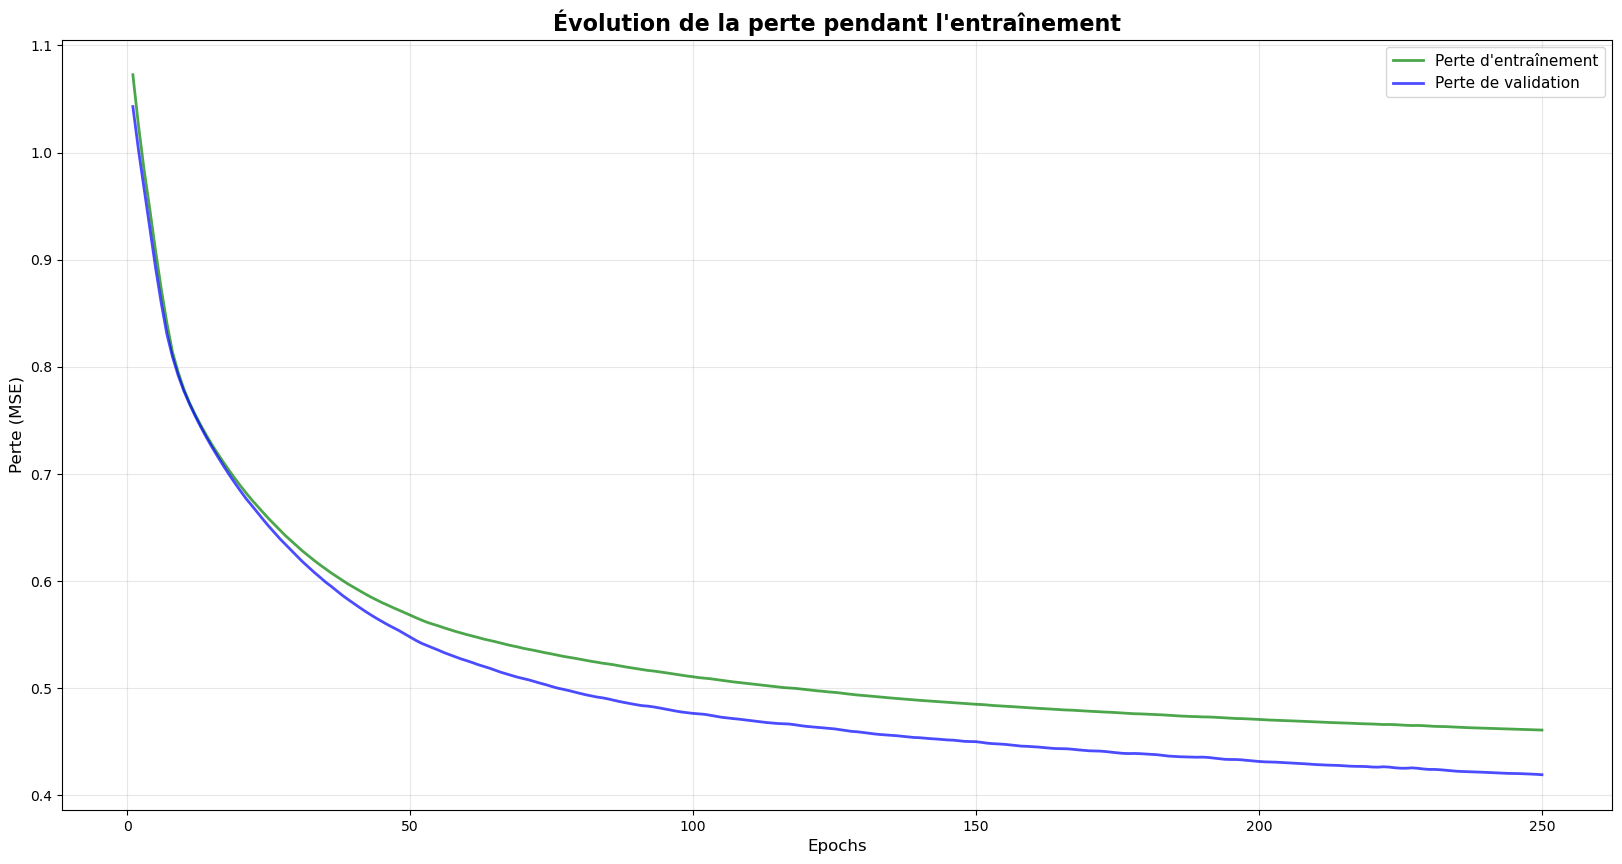

📊 Graphique généré avec 250 epochs
   - Perte finale d'entraînement : 0.4609
   - Perte finale de validation : 0.4192


In [6]:
# Définir la taille des graphiques (largeur, hauteur en pouces)
plt.rcParams["figure.figsize"] = (20, 10)

# Extraire les valeurs de perte de l'historique d'entraînement
loss = history.history['loss']           # Perte sur les données d'entraînement
val_loss = history.history['val_loss']  # Perte sur les données de validation
epochs = range(1, len(loss) + 1)        # Numéros des epochs (1, 2, 3, ...)

# Créer le graphique
plt.plot(epochs, loss, 'g-', label='Perte d\'entraînement', linewidth=2, alpha=0.7)
plt.plot(epochs, val_loss, 'b-', label='Perte de validation', linewidth=2, alpha=0.7)
plt.title('Évolution de la perte pendant l\'entraînement', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Perte (MSE)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print(f"📊 Graphique généré avec {len(loss)} epochs")
print(f"   - Perte finale d'entraînement : {loss[-1]:.4f}")
print(f"   - Perte finale de validation : {val_loss[-1]:.4f}")

### 🔍 Graphique de la perte (zoom sur la convergence)

Pour verifier si je peux augmenter le nombre d'epochs

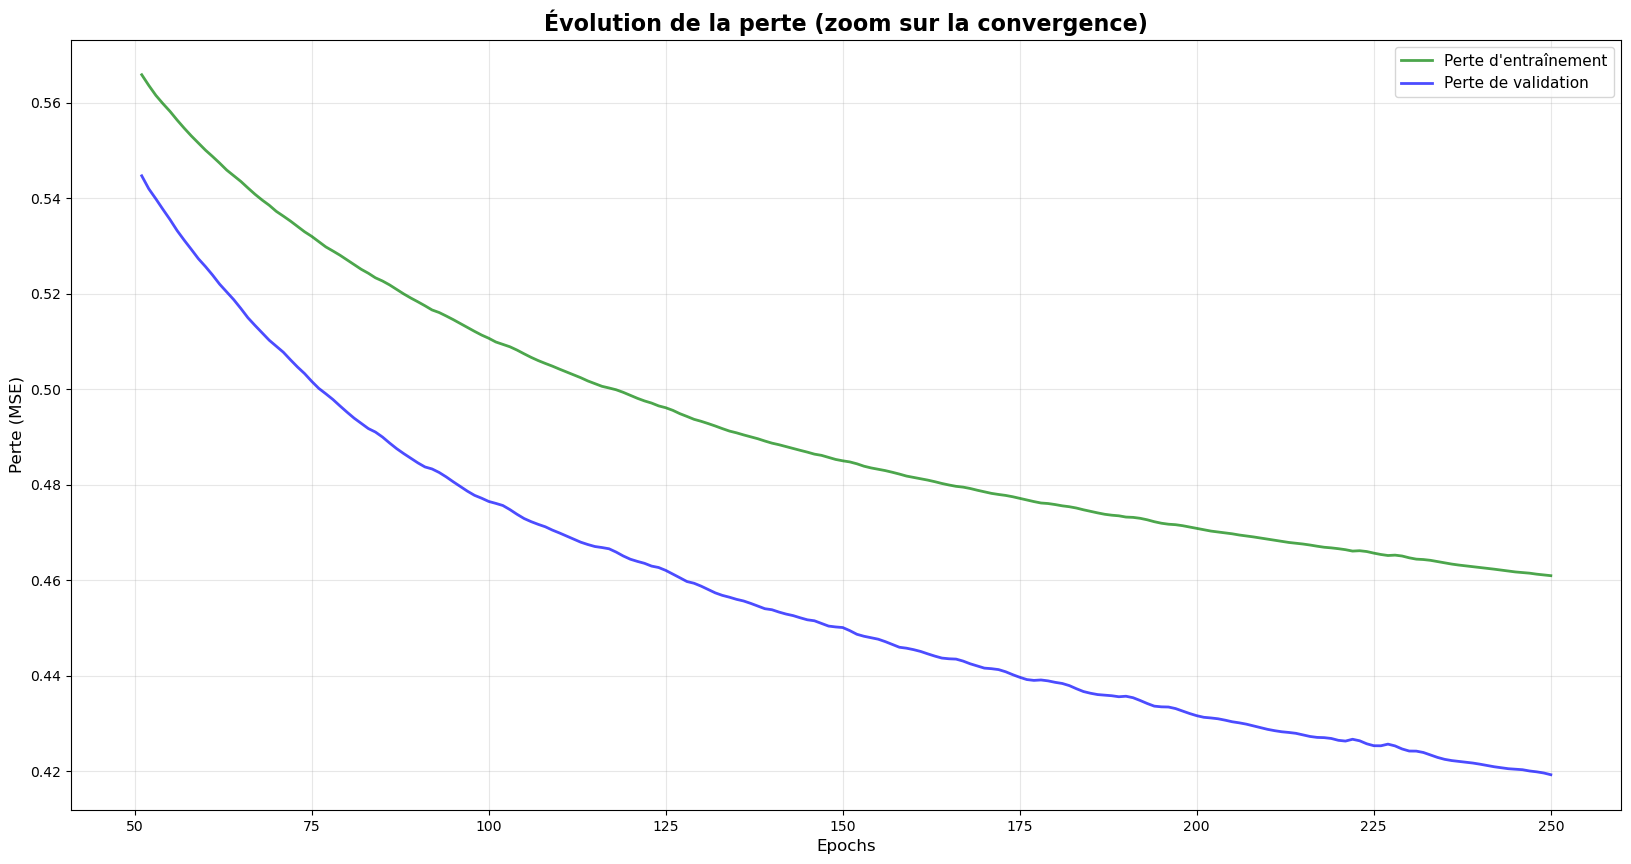

🔍 Vue zoomée à partir de l'epoch 51


In [7]:
# Graphique de la perte en sautant les premiers epochs
# Cela permet de mieux voir la convergence (stabilisation) du modèle
SKIP = 50# Ignorer les 50 premiers epochs

plt.plot(epochs[SKIP:], loss[SKIP:], 'g-', label='Perte d\'entraînement', linewidth=2, alpha=0.7)
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b-', label='Perte de validation', linewidth=2, alpha=0.7)
plt.title('Évolution de la perte (zoom sur la convergence)', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Perte (MSE)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print(f"🔍 Vue zoomée à partir de l'epoch {SKIP+1}")

### 📊 Graphique de l'accuracy


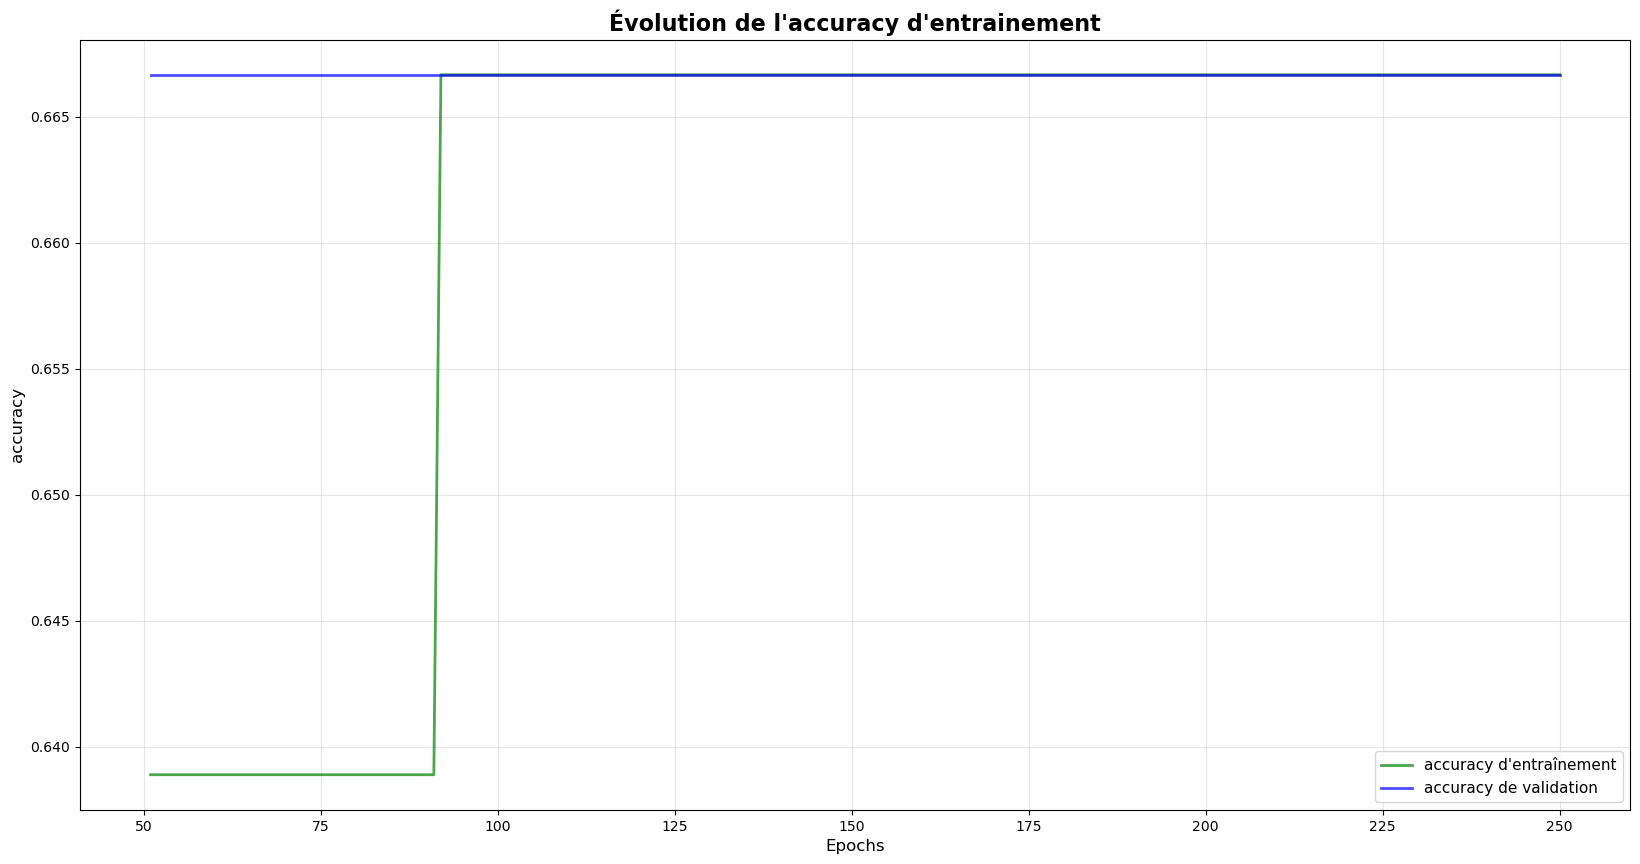

📊 Accuracy finale :
   - Entraînement : 0.6667
   - Validation   : 0.6667


In [8]:
# Graphique de l'accuracy
accuracy = history.history['accuracy']           # accuracy sur les données d'entraînement
val_accuracy = history.history['val_accuracy']  # accuracy sur les données de validation

plt.plot(epochs[SKIP:], accuracy[SKIP:], 'g-', label='accuracy d\'entraînement', linewidth=2, alpha=0.7)
plt.plot(epochs[SKIP:], val_accuracy[SKIP:], 'b-', label='accuracy de validation', linewidth=2, alpha=0.7)
plt.title('Évolution de l\'accuracy d\'entrainement', fontsize=16, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print(f"📊 Accuracy finale :")
print(f"   - Entraînement : {accuracy[-1]:.4f}")
print(f"   - Validation   : {val_accuracy[-1]:.4f}")


### 🧪 Tester avec les données de test

🔮 Génération des prédictions sur les données de test...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

📊 Résultats de prédiction :
Prédictions (probabilités) :
[[0.505 0.002 0.493]
 [0.51  0.002 0.488]
 [0.509 0.002 0.489]
 [0.51  0.002 0.488]
 [0.    1.    0.   ]
 [0.    1.    0.   ]
 [0.534 0.002 0.464]
 [0.797 0.029 0.174]
 [0.    1.    0.   ]
 [0.    1.    0.   ]
 [0.508 0.002 0.49 ]
 [0.514 0.002 0.484]]

Vraies valeurs (labels) :
[[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]

✅ Précision sur les données de test : 58.3% (7/12)
   Geste prédit = index avec la probabilité la plus élevée


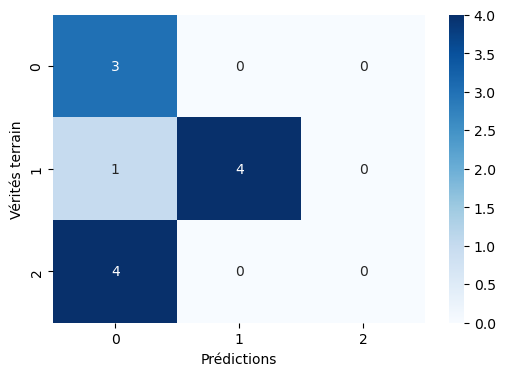

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
# Utiliser le modèle pour prédire sur les données de test
print("🔮 Génération des prédictions sur les données de test...")

predictions = model.predict(inputs_test, verbose=1)

# Afficher les prédictions et les vraies valeurs
print("\n📊 Résultats de prédiction :")
print("=" * 60)
print("Prédictions (probabilités) :")
print(np.round(predictions, decimals=3))
print("\nVraies valeurs (labels) :")
print(outputs_test)

# Calculer la précision
true_gest=[]
pred_gest=[]
correct = 0
for i in range(len(predictions)):
    pred_gesture = np.argmax(predictions[i])  # Index du geste prédit
    true_gesture = np.argmax(outputs_test[i])  # Index du vrai geste
    true_gest.append(true_gesture)
    pred_gest.append(pred_gesture)
    if pred_gesture == true_gesture:
        correct += 1

accuracy = correct / len(predictions) * 100
print(f"\n✅ Précision sur les données de test : {accuracy:.1f}% ({correct}/{len(predictions)})")
print(f"   Geste prédit = index avec la probabilité la plus élevée")

# Création de la matrice de confusion
cm = confusion_matrix(true_gest, pred_gest)

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédictions")
plt.ylabel("Vérités terrain")
plt.show()

## 📦 Convertir le modèle en TensorFlow Lite

### Pourquoi TensorFlow Lite ?

**TensorFlow Lite (TFLite)** est une version optimisée de TensorFlow pour les appareils embarqués :

- **Taille réduite** : Modèle compressé pour tenir dans la mémoire limitée d'Arduino
- **Performance** : Optimisé pour les microcontrôleurs
- **Compatibilité** : Format standard pour TinyML

### Conversion

Le modèle TensorFlow standard est converti en format `.tflite` qui peut être utilisé sur Arduino avec la bibliothèque TensorFlow Lite for Microcontrollers.

**Taille importante :** Plus le modèle est petit, plus il sera rapide sur Arduino. Notre objectif est généralement < 100 KB.

In [ ]:
# ============================================
# CONVERSION EN TENSORFLOW LITE
# ============================================
# Convertir le modèle Keras en format TensorFlow Lite
# Note: Conversion sans quantification (utilise des float32)
# La quantification (int8) réduirait encore plus la taille mais nécessite plus de configuration
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Sauvegarder le modèle sur le disque
with open("../models/vibration_model.tflite", "wb") as f:
    f.write(tflite_model)

# Afficher la taille du modèle
import os
basic_model_size = os.path.getsize("../models/vibration_model.tflite")
print(f"✅ Modèle converti avec succès !")
print(f"📦 Taille du modèle : {basic_model_size:,} bytes ({basic_model_size/1024:.2f} KB)")

# Vérifier si la taille est acceptable pour Arduino
if basic_model_size < 100 * 1024:  # < 100 KB
    print("   ✓ Taille acceptable pour Arduino Nano 33 BLE Sense")
else:
    print("   ⚠️ Modèle assez volumineux, considérez la quantification pour réduire la taille")



INFO:tensorflow:Assets written to: C:\Users\djidi\AppData\Local\Temp\tmpf4he0d1c\assets


INFO:tensorflow:Assets written to: C:\Users\djidi\AppData\Local\Temp\tmpf4he0d1c\assets


Saved artifact at 'C:\Users\djidi\AppData\Local\Temp\tmpf4he0d1c'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 6), dtype=tf.float32, name='keras_tensor_17')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2350759283984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2350759286480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2350759284944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2350759281296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2350759291280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2350759289360: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Modèle converti avec succès !
📦 Taille du modèle : 3,636 bytes (3.55 KB)
   ✓ Taille acceptable pour Arduino Nano 33 BLE Sense


## 🔧 Encoder le modèle dans un fichier header Arduino

### Pourquoi un fichier header ?

Arduino ne peut pas lire directement un fichier `.tflite`. Il faut **intégrer le modèle directement dans le code** comme un tableau de bytes.

### Processus

1. Lire le fichier `.tflite` (binaire)
2. Convertir chaque byte en format hexadécimal (`0x00`, `0xFF`, etc.)
3. Créer un tableau C++ `const unsigned char model[]`
4. Sauvegarder dans `model.h`

### Utilisation sur Arduino

Le fichier `model.h` généré doit être :
- Ajouté comme un onglet dans votre sketch Arduino
- Inclus avec `#include "model.h"`
- Utilisé par la bibliothèque TensorFlow Lite for Microcontrollers

In [ ]:
# ============================================
# CONVERSION EN FICHIER HEADER C++
# ============================================
def convert_tflite_to_header(tflite_file, header_file):
    """
    Convertit un fichier TFLite en fichier header C++ compatible Arduino.
    
    Le modèle binaire est converti en un tableau de bytes hexadécimaux
    qui peut être inclus directement dans le code Arduino.
    """
    # Lire le fichier TFLite (mode binaire)
    with open(tflite_file, 'rb') as f:
        tflite_data = f.read()
    
    # Créer le fichier header C++
    with open(header_file, 'w', encoding='utf-8') as f:
        # En-tête du fichier
        f.write("// Modèle TensorFlow Lite pour Arduino\n")
        f.write("// Généré automatiquement - Ne pas modifier manuellement\n\n")
        
        # Déclaration du tableau de bytes
        # __attribute__((aligned(4))) : Alignement sur 4 bytes pour optimiser l'accès mémoire
        f.write("const unsigned char model[] __attribute__((aligned(4))) = {\n")
        
        # Convertir les bytes en format hexadécimal
        # Format: 12 bytes par ligne pour une meilleure lisibilité
        for i in range(0, len(tflite_data), 12):
            chunk = tflite_data[i:i+12]
            # Convertir chaque byte en hexadécimal (0x00 à 0xFF)
            hex_values = ', '.join(f"0x{b:02x}" for b in chunk)
            # Ajouter une virgule sauf pour le dernier chunk
            comma = "," if i + 12 < len(tflite_data) else ""
            f.write(f"  {hex_values}{comma}\n")
        
        f.write("};\n\n")
        
        # Ajouter la longueur du modèle (utile pour certaines bibliothèques)
        f.write(f"const unsigned int model_len = {len(tflite_data)};\n")

# Convertir le modèle
print("🔄 Conversion du modèle en fichier header C++...")
convert_tflite_to_header("../models/vibration_model.tflite", "../../3-Inference_Arduino/inference_vibration/model.h")

# Afficher la taille du fichier généré
import os
model_h_size = os.path.getsize("../../3-Inference_Arduino/inference_vibration/model.h")
print(f"✅ Fichier header créé avec succès !")
print(f"📄 Taille du fichier model.h : {model_h_size:,} bytes ({model_h_size/1024:.2f} KB)")
print(f"\n📋 Prochaines étapes :")
print(f"   1. Ouvrez le fichier model.h dans votre éditeur")
print(f"   2. Ajoutez-le comme onglet dans votre sketch Arduino")
print(f"   3. Utilisez-le avec TensorFlow Lite for Microcontrollers")

🔄 Conversion du modèle en fichier header C++...
✅ Fichier header créé avec succès !
📄 Taille du fichier model.h : 22,933 bytes (22.40 KB)

📋 Prochaines étapes :
   1. Ouvrez le fichier model.h dans votre éditeur
   2. Ajoutez-le comme onglet dans votre sketch Arduino
   3. Utilisez-le avec TensorFlow Lite for Microcontrollers
